In [208]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import scipy

df = pd.read_csv("data.csv", delimiter=";", header=None)
df = df.rename(columns={0: "timestamp", 1: "K", 2: "N", 3: "rep_no", 4: "time", 5: "error_count"})
# df

In [209]:
# PLOTS
FIG_WIDTH = 6.9
golden_ratio = (5**.5 - 1) / 2
FIG_SIZE = (FIG_WIDTH, golden_ratio * FIG_WIDTH)
AX_LABELS_FONT = 20
TICKS_FONT = 16
LEGEND_FONT = 18
TITLE_FONT = 22

In [210]:
max_N = df["N"].max()
min_N = df["N"].min()
print(min_N, max_N)

4 16


In [211]:
max_K = df["K"].max()
min_K = df["K"].min()
print(min_K, max_K)

1 24


In [212]:
for n in range(min_N, max_N+1):
    for k in range(min_K, max_K+1):
        cnt = len(df.loc[(df["N"]==n) & (df["K"]==k)])
        if cnt != 20 and cnt != 0:
            print(f"N={n}, K={k}, REPS={cnt}")
df

N=4, K=1, REPS=40
N=4, K=2, REPS=26
N=6, K=14, REPS=31
N=7, K=21, REPS=39
N=10, K=18, REPS=40


timestamp   K   N  rep_no      time  error_count
0     31/01/2022-02:02:54   1   4       0    0.9112            0
1     31/01/2022-02:03:01   1   4       1    0.8910            0
2     31/01/2022-02:03:07   1   4       2    0.8935            0
3     31/01/2022-02:03:14   1   4       3    0.8974            0
4     31/01/2022-02:03:20   1   4       4    0.8788            0
...                   ...  ..  ..     ...       ...          ...
6311  06/02/2022-14:14:33  24  16      15  122.3124            0
6312  06/02/2022-14:16:49  24  16      16  106.5167            0
6313  06/02/2022-14:18:55  24  16      17  101.6587            0
6314  06/02/2022-14:20:59  24  16      18  102.1929            0
6315  06/02/2022-14:23:00  24  16      19  101.1575            0

[6316 rows x 6 columns]

In [213]:
# "%d/%m/%Y-%H:%M:%S"
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["timestamp"] = df["timestamp"].dt.strftime("%d/%m/%Y-%H:%M:%S")
df

timestamp   K   N  rep_no      time  error_count
0     31/01/2022-02:02:54   1   4       0    0.9112            0
1     31/01/2022-02:03:01   1   4       1    0.8910            0
2     31/01/2022-02:03:07   1   4       2    0.8935            0
3     31/01/2022-02:03:14   1   4       3    0.8974            0
4     31/01/2022-02:03:20   1   4       4    0.8788            0
...                   ...  ..  ..     ...       ...          ...
6311  02/06/2022-14:14:33  24  16      15  122.3124            0
6312  02/06/2022-14:16:49  24  16      16  106.5167            0
6313  02/06/2022-14:18:55  24  16      17  101.6587            0
6314  02/06/2022-14:20:59  24  16      18  102.1929            0
6315  02/06/2022-14:23:00  24  16      19  101.1575            0

[6316 rows x 6 columns]

In [214]:
for n in range(min_N, max_N+1):
    for k in range(min_K, max_K+1):
        cnt = len(df.loc[(df["N"]==n) & (df["K"]==k)])
        if cnt > 20:
            # print(df.head)
            df.drop(index = df.loc[(df["N"]==n) & (df["K"]==k)].sort_values(by="timestamp", ascending=True).index[-20:],
                    axis = 0,
                    inplace = True)
        elif cnt < 20 and cnt != 0:
            df = df.drop(df.loc[(df["N"]==n) & (df["K"]==k)].index)

In [215]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


def my_remove_outlier(df_in, col_name, n, k):
    q1 = df_in[col_name].loc[(df_in["N"]==n) & (df_in["K"]==k)].quantile(0.25)
    q3 = df_in[col_name].loc[(df_in["N"]==n) & (df_in["K"]==k)].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_in = df_in.drop(df.loc[(df_in["N"]==n) & (df_in["K"]==k) & ((df_in[col_name] < fence_low) | (df_in[col_name] > fence_high))].index)
    return df_in


In [216]:
for n in range(min_N, max_N+1):
    for k in range(min_K, max_K+1):
        expe = df.loc[(df["N"]==n) & (df["K"]==k)]
        cnt = len(expe)
        if cnt != 0:
            df = my_remove_outlier(df, "time", n, k)

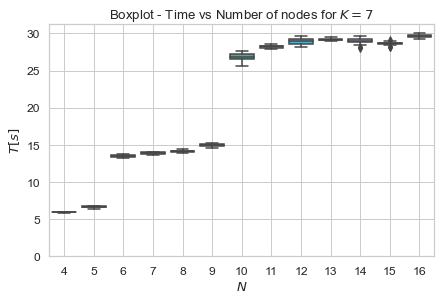

In [217]:
k = 7
ax = sns.boxplot(x = "N", y = "time", data=df[df["K"]==k], showfliers=True)
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$T[s]$")
ax.set_title(fr"Boxplot - Time vs Number of nodes for $K = {k}$")
ax.set_ylim((0, None))
ax.grid(True)
plt.savefig("time_vs_no_nodes.pdf")

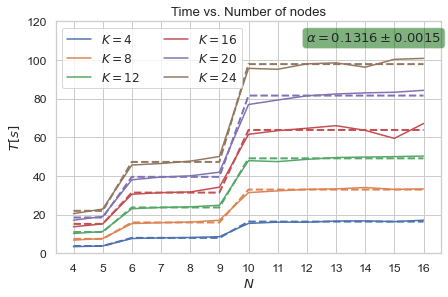

In [218]:
fig = plt.figure()
ax = fig.add_subplot(111)

slopes = []

for k in range(min_K, max_K+1, 1):
    means = [df[(df["K"]==k) & (df["N"]==i)]["time"].mean() for i in range(min_N, max_N+1)]
    y = np.array(means)    

    theory = [k * 2 ** math.ceil(math.log2(i-1)+1) - 1 for i in range(min_N, max_N+1)]
    theory = np.array(theory)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(theory, y)

    slopes.append(slope)
    # print(r_value ** 2)
    # print(slope, intercept)
    if k % 4 == 0:
        line, = ax.plot(np.arange(min_N, max_N+1), slope * theory + intercept, linewidth=2.0, linestyle="dashed")
        ax.plot(np.arange(min_N, max_N+1), y, color=line.get_color(), label=fr"$K={k}$")
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$T[s]$")
ax.set_title(r"Time vs. Number of nodes")
ax.set_xticks(np.arange(min_N, max_N+1))
ax.set_yticks(20 * np.arange(0,7))
ax.set_ylim((0, None))
ax.grid(True, which="major")
ax.legend(ncol=2)

props = dict(boxstyle='round', facecolor='darkgreen', alpha=0.5)
ax.text(0.65, 0.90, fr"$\alpha = {np.mean(slopes):.4f} \pm {np.std(slopes):.4f}$", transform=ax.transAxes,
        verticalalignment='bottom', bbox=props)
plt.savefig("time_vs_no_nodes_all.pdf")

# print(np.mean(slopes))

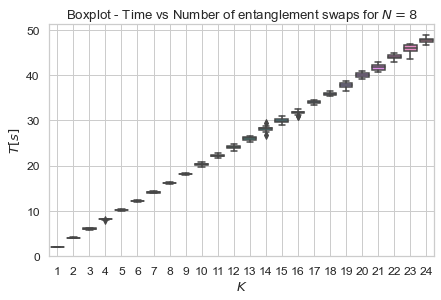

In [219]:
ax = sns.boxplot(x = "K", y = "time", data=df[df["N"]==8])
ax.set_xlabel(r"$K$")
ax.set_ylabel(r"$T[s]$")
ax.set_ylim((0, None))
ax.set_title(fr"Boxplot - Time vs Number of entanglement swaps for $N = 8$")
ax.grid(True)
plt.savefig("time_vs_no_swaps.pdf")

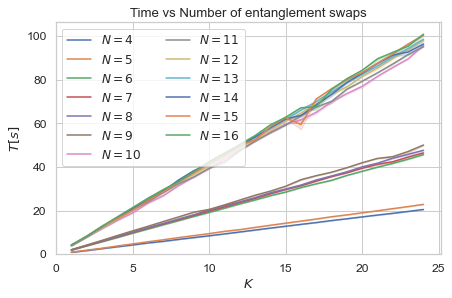

In [220]:
fig, ax = plt.subplots()

for n in range(min_N, max_N + 1):
    if n % 1 == 1:
        continue
    sns.lineplot(data=df[df["N"]==n], x="K", y="time", ax=ax, label=rf"$N = {n}$")
ax.set_xlabel(r"$K$")
ax.set_ylabel(r"$T[s]$")
ax.set_xlim((0, None))
ax.set_ylim((0, None))
ax.set_title(fr"Time vs Number of entanglement swaps")
ax.grid(True)
ax.legend(ncol=2)
plt.savefig("time_vs_no_swaps_all.pdf")